# SmartSat Hyperspectral Notes

#### Imports



In [3]:
## Imports

import os
import glob
import json
import joblib
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from rios import applier, fileinfo
from netCDF4 import Dataset
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull


gdal.UseExceptions()



## ENMAP

Search for [ENMAP](https://explore.eo-lab.org/search)

ENMAP comes as PIXEL interleaved COG, it's slow to open in QGIS. I run the `src/reformat_enmap.sh` shell script to reformat it to tiled BAND interleaved with tiled overviews


## EMIT

Search for [EMIT](https://earth.jpl.nasa.gov/emit/data/data-portal/coverage-and-forecasts/)

### Importing EMIT data
The `src/gdal_import_emit.py` script can be used to import EMIT data into GDAL formats, applying the GLT so the data is mapped to a grid.

### Sampling EMIT NETCDF


/tmp/ipykernel_93313/935755787.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  dat = np.array(nc_ds['reflectance'])


Mask file does not exist. Skipping masking.
Shape after removing wild values: (285, 1589739)


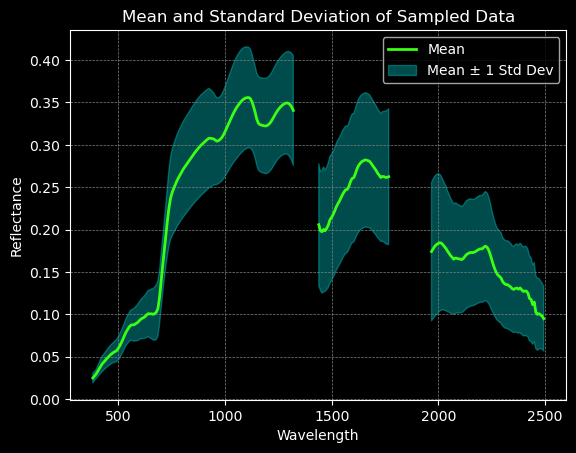

In [6]:

import numpy as np
from netCDF4 import Dataset
import os

def extract_and_mask_data(emit_file):
    mask_file = emit_file.replace('RFL', 'MASK')
    
    # Extract variables and metadata from the NetCDF file
    nc_ds = Dataset(emit_file, 'r', format='NETCDF4')
    dat = np.array(nc_ds['reflectance'])
    # Reshape/rotate to (bands, lines, columns)
    dat = np.moveaxis(dat, 2, 0)
    # Reshape to (bands, pixels)
    dat = dat.reshape((dat.shape[0], -1))
    # Create an x-axis for plotting
    wavelengths = nc_ds.groups.get('sensor_band_parameters').variables['wavelengths'][:]
    nc_ds.close()
    
    # Check if mask file exists
    if os.path.exists(mask_file):
        # Extract the mask from the NetCDF file
        nc_ds = Dataset(mask_file, 'r', format='NETCDF4')
        mask = np.array(nc_ds['mask'])
        # Aggregate mask is the 7th band
        mask = mask[:, :, 7] == 0
        # Reshape/rotate to (lines, columns)
        mask = np.moveaxis(mask, 1, 0)
        # Reshape to (pixels)
        mask = mask.reshape(-1)
        nc_ds.close()
        
        # Mask the data
        print("Original shape:", dat.shape)
        dat = dat[:, mask]
        print("Shape after masking:", dat.shape)
    else:
        print("Mask file does not exist. Skipping masking.")

    # Remove wild values
    dat = dat[:, np.max(dat, axis=0) < 0.9]
    print("Shape after removing wild values:", dat.shape)
    
    return dat, wavelengths


def plot_data(dat, wavelengths):
    # Plot the mean and standard deviation of the sampled data
    mean = np.mean(dat, axis=1)
    std_dev = np.std(dat, axis=1)

    # Mask values less than 0 by setting them to NaN
    mean[mean < 0] = np.nan
    std_dev[std_dev < 0] = np.nan

    # Set the black background
    plt.style.use('dark_background')

    # Plot the mean with a neon color
    plt.plot(wavelengths, mean, label='Mean', color='#39FF14', linewidth=2)  # Neon green line

    # Plot the standard deviation as a shaded area with a neon color
    plt.fill_between(wavelengths, mean - std_dev, mean + std_dev, color='#00FFFF', alpha=0.3, label='Mean ± 1 Std Dev')  # Neon cyan shading

    # Customize the plot with labels, title, legend, and grid
    plt.xlabel('Wavelength', color='white')
    plt.ylabel('Reflectance', color='white')
    plt.title('Mean and Standard Deviation of Sampled Data', color='white')
    plt.legend()
    plt.grid(color='gray', linestyle='--', linewidth=0.5)

    # Show the plot
    plt.show()

# Usage:
emit_file = '/mnt/e/Temp/EMIT_L2A_RFL_001_20241029T023511_2430302_055.nc'
dat, wavelengths = extract_and_mask_data(emit_file)
plot_data(dat, wavelengths)


## Clean the DATA

In [7]:
# Find the indicies of the bands where the minumum is all less than 0
bad_bands = np.all(dat < 0, axis=1)
print(f'Bad bands: {np.where(bad_bands)[0]}')

# Remove outliers using sklearn IsolationForest
clf = IsolationForest(contamination=0.05)
outliers = clf.fit_predict(dat.T)
sampled_data = dat[:, outliers == 1].T
# Print the proportion of outliers
print(f'Proportion of outliers: {np.sum(outliers == -1) / len(outliers)}')

# Subsample a maximum of 1 million pixels
num_samples = 1000000
sample_pixels = np.random.choice(sampled_data.shape[0], min(num_samples,sampled_data.shape[0]), replace=False)
sampled_data = sampled_data[sample_pixels]
print(sampled_data.shape)

# Save the sampled data to a NumPy file
np.save('data/sampled_data.npy', sampled_data)


Bad bands: [127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 187 188 189
 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212]
Proportion of outliers: 0.05000003145170371
(1000000, 285)


FileNotFoundError: [Errno 2] No such file or directory: 'data/sampled_data.npy'

### SMACC

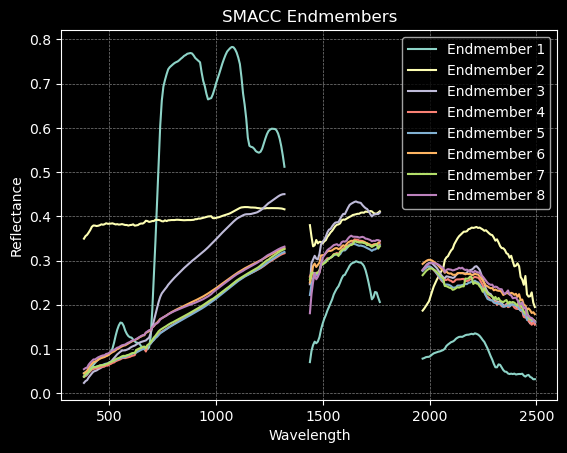

In [ ]:
def smacc(spectra, min_endmembers=None, max_residual_norm=float('Inf')):
    '''Returns SMACC decomposition (H = F * S + R) matrices for an image or
    array of spectra.

    Let `H` be matrix of shape NxB, where B is number of bands, and N number of
    spectra, then if `spectra` is of the same shape, `H` will be equal to `spectra`.
    Otherwise, `spectra` is assumed to be 3D spectral image, and it is reshaped
    to match shape of `H`.

    Arguments:

        `spectra` (ndarray):

            Image data for which to calculate SMACC decomposition matrices.

        `min_endmembers` (int):

            Minimal number of endmembers to find. Defaults to rank of `H`,
            computed numerically with `numpy.linalg.matrix_rank`.

        `max_residual_norm`:

            Maximum value of residual vectors' norms. Algorithm will keep finding
            new endmembers until max value of residual norms is less than this
            argument. Defaults to float('Inf')

    Returns:
        3 matrices, S, F and R, such that H = F * S + R (but it might not always hold).
        F is matrix of expansion coefficients of shape N x num_endmembers.
        All values of F are equal to, or greater than zero.
        S is matrix of endmember spectra, extreme vectors, of shape num_endmembers x B.
        R is matrix of residuals of same shape as H (N x B).

        If values of H are large (few tousands), H = F * S + R, might not hold,
        because of numeric errors. It is advisable to scale numbers, by dividing
        by 10000, for example. Depending on how accurate you want it to be,
        you can check if H is really strictly equal to F * S + R,
        and adjust R: R = H - np.matmul(F, S).

    References:

        John H. Gruninger, Anthony J. Ratkowski, and Michael L. Hoke "The sequential
        maximum angle convex cone (SMACC) endmember model", Proc. SPIE 5425, Algorithms
        and Technologies for Multispectral, Hyperspectral, and Ultraspectral Imagery X,
        (12 August 2004); https://doi.org/10.1117/12.543794
    '''    
    # Flatten 3D spectral image to 2D if necessary
    H = spectra.reshape((-1, spectra.shape[2])) if spectra.ndim == 3 else spectra
    
    R = H.copy()
    Fs = []
    q = []  # Indices of selected vectors in S
    
    # Set default minimum endmembers
    if min_endmembers is None:
        min_endmembers = np.linalg.matrix_rank(H)

    residual_norms = np.linalg.norm(H, axis=1)
    current_max_residual_norm = np.max(residual_norms)
    
    if max_residual_norm is None:
        max_residual_norm = current_max_residual_norm / min_endmembers

    while len(q) < min_endmembers or current_max_residual_norm > max_residual_norm:
        idx = np.argmax(residual_norms)
        q.append(idx)
        
        # Calculate projection coefficients
        w = R[idx]
        wt = w / np.dot(w, w)
        On = np.dot(R, wt)
        alpha = np.ones_like(On)
        
        # Adjust alphas for oblique projection
        for k in range(len(Fs)):
            t = On * Fs[k][idx]
            t[t == 0.0] = 1e-10
            alpha = np.minimum(Fs[k] / t, alpha, where=t != 0.0)
        
        # Clip negative projection coefficients
        alpha[On <= 0.0] = 0.0
        alpha[idx] = 1.0
        
        # Calculate oblique projection coefficients
        Fn = alpha * On.clip(min=0.0)
        R -= np.outer(Fn, w)
        
        # Update existing factors
        for k in range(len(Fs)):
            Fs[k] -= Fs[k][idx] * Fn
            Fs[k] = Fs[k].clip(min=0.0)
        
        Fs.append(Fn)
        residual_norms = np.linalg.norm(R, axis=1)
        current_max_residual_norm = np.max(residual_norms)
        
        print(f'Found {len(q)} endmembers, current max residual norm is {current_max_residual_norm:.4f}\r', end='')

    # Correction as suggested in the SMACC paper.
    for k, s in enumerate(q):
        Fs[k][q] = 0.0
        Fs[k][s] = 1.0

    F = np.column_stack(Fs).T
    S = H[q]

    return S, F, R


S, F, R = smacc(sampled_data, min_endmembers=8, max_residual_norm=5)

# Plot the endmembers
plt.style.use('dark_background')
for i in range(S.shape[0]):
    endmember = S[i]
    endmember[endmember < 0] = np.nan
    plt.plot(wavelengths, endmember, label=f'Endmember {i+1}')
plt.xlabel('Wavelength', color='white')
plt.ylabel('Reflectance', color='white')
plt.title('SMACC Endmembers', color='white')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

### NFINDr

Cumulative PCA Explained Variance = [0.8179122  0.9823138  0.9925295  0.9962438  0.9974346  0.99841434
 0.9988832  0.99921614]


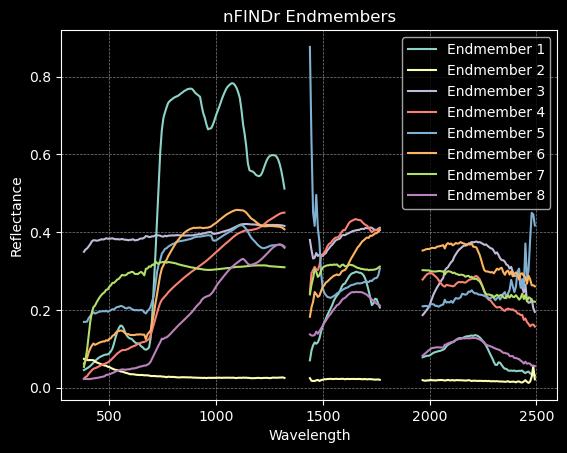

In [ ]:

def nfindr(srData,n_components=0.999):
    """
    Extract endmembers from spectral data using the NFINDR algorithm.
    
    Parameters:
    - srData (ndarray): Input spectral reflectance data of shape (bands, samples).
    - nSubsets (int, optional): Number of subsets for subsampling. Defaults to None.
    
    Returns:
    - endmembers (ndarray): Detected endmember spectra.
    """

    # Compute the PCA
    pca = PCA(n_components=n_components)
    pcaData = pca.fit_transform(srData)
    
    # Calculate cumulative explained variance
    cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
    print(f'Cumulative PCA Explained Variance = {cumulative_explained_variance}')
    
    # First two endmembers are the extremes of PCA component 1
    sub = np.array([np.argmax(pcaData[:, 0]), np.argmin(pcaData[:, 0])])

    # Loop to find remaining endmembers
    for nEdge in range(3, pcaData.shape[1] + 1):
        dmax = 0
        endMatrix = np.ones(nEdge)

        for i in range(nEdge - 1):
            endMatrix = np.vstack((endMatrix, np.append(pcaData[sub, i], 0)))

        # Test every pixel to find new endmember
        for i in range(len(pcaData)):
            endMatrix[1:nEdge, nEdge - 1] = pcaData[i, 0:nEdge - 1]
            
            # Calculate volume of the simplex
            volume = np.abs(np.linalg.det(endMatrix))
            
            if volume > dmax and i not in sub:
                dmax = volume
                subn = i
        
        print(f"Completed {nEdge} search\r", end='')
        sub = np.append(sub, subn)

    # Extract the endmembers in actual reflectance
    endmembers = srData[sub]
    return endmembers

S = nfindr(sampled_data, 0.999)

# Plot the endmembers
plt.style.use('dark_background')
for i in range(S.shape[0]):
    endmember = S[i]
    endmember[endmember < 0] = np.nan
    plt.plot(wavelengths, endmember, label=f'Endmember {i+1}')
plt.xlabel('Wavelength', color='white')
plt.ylabel('Reflectance', color='white')
plt.title('nFINDr Endmembers', color='white')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)


### QHULL

Cumulative PCA Explained Variance = [0.8179122 0.9823138 0.9925295]


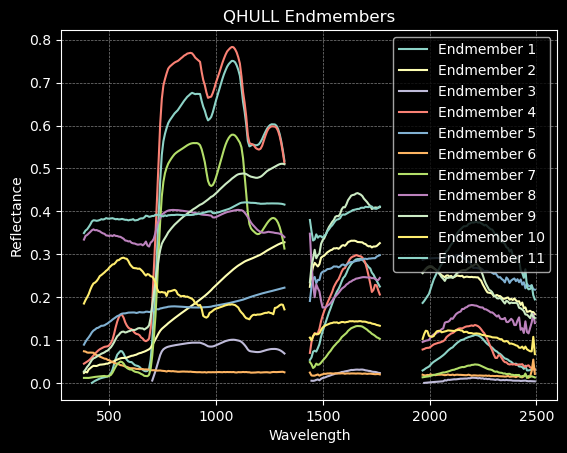

In [ ]:


def qhull_endmembers(data,n_components=0.99):
    """
    Finds the edges of the data simplex using QHULL to find the endmembers.
    
    Parameters:
    data (numpy.ndarray): The input data, expected to be 2D (pixels x bands).
    subsize (int): The maximum number of pixels to use for the analysis.

    Returns:
    realsig (numpy.ndarray): The real signatures from the data.
    """


    # Perform PCA transformation
    pca = PCA(n_components=n_components)
    pc = pca.fit_transform(data)
    
    # Calculate cumulative explained variance
    cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
    print(f'Cumulative PCA Explained Variance = {cumulative_explained_variance}')
    
    # Use Qhull via ConvexHull to find the extreme points
    # Fx print extreme points (vertices) of convex hulls
    # W0.1 min distance above plane for outside points to approximate the convex hull
    # QbB  - scale the input to fit the unit cube
    hull = ConvexHull(pc, qhull_options='Fx W0.1 QbB')

    # Extract the real signatures
    realsig = data[hull.vertices]

    return realsig

S = qhull_endmembers(sampled_data)

# Plot the endmembers
plt.style.use('dark_background')
for i in range(S.shape[0]):
    endmember = S[i]
    endmember[endmember < 0] = np.nan
    plt.plot(wavelengths, endmember, label=f'Endmember {i+1}')
plt.xlabel('Wavelength', color='white')
plt.ylabel('Reflectance', color='white')
plt.title('QHULL Endmembers', color='white')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)


### NMF

TODO - Make this work :)

/home/pete/miniconda3/envs/emit/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


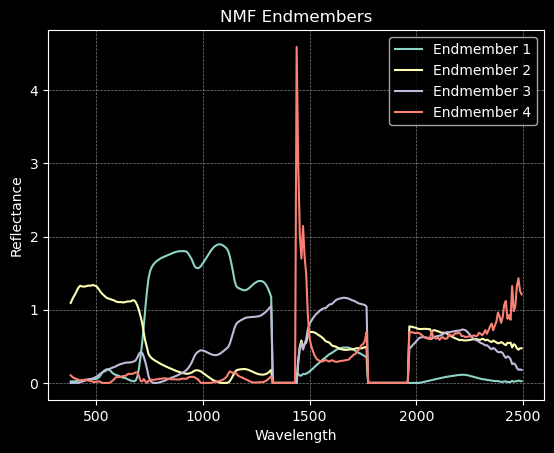

In [ ]:
# User NMF to extract endmembers
from sklearn.decomposition import NMF

sampled_positive = np.clip(sampled_data, 0, None)
# Subsample the data to 1000 pixels
sampled_positive = sampled_positive[np.random.choice(sampled_positive.shape[0], 10000, replace=False)]


 # Compute the NMF
nmf = NMF(n_components=4, init='nndsvd', max_iter=1000)
W = nmf.fit_transform(sampled_positive)
H = nmf.components_


# Plot the endmembers
plt.style.use('dark_background')
for i in range(H.shape[0]):
    endmember = H[i]
    endmember[endmember < 0] = np.nan
    plt.plot(wavelengths, endmember, label=f'Endmember {i+1}')
plt.xlabel('Wavelength', color='white')
plt.ylabel('Reflectance', color='white')
plt.title('NMF Endmembers', color='white')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)


### Test Generative topographic mapping using UGTM

Needs the uGTM python installation

ToDo: Make this work :)

(1000, 285)


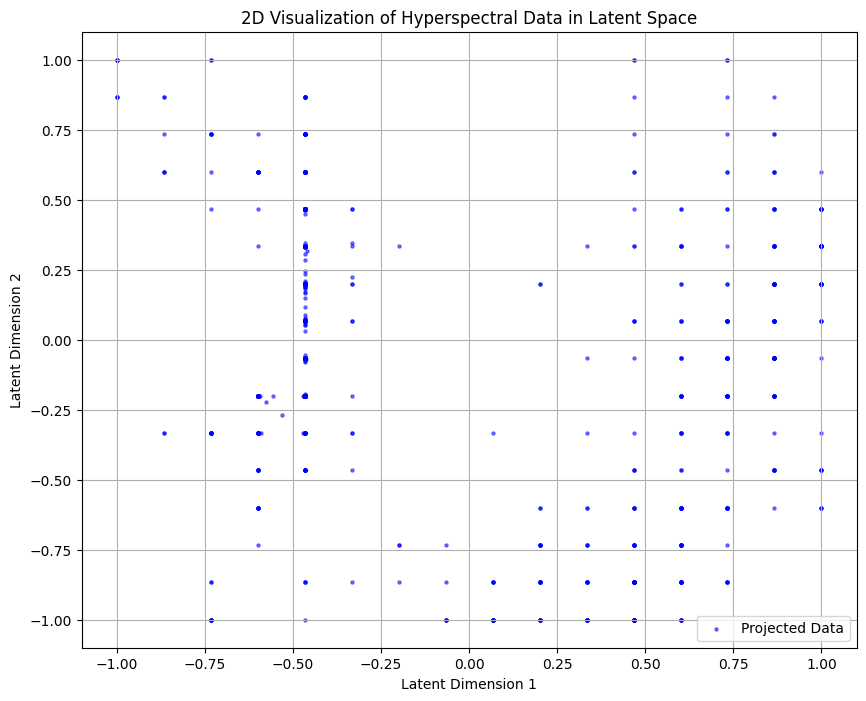

In [2]:
%matplotlib inline

import numpy as np
from ugtm import eGTM
import matplotlib.pyplot as plt

# Import the sample data
sampled_data = np.load('data/sampled_data.npy')

# Subsample the data
num_samples = 1000 
hyperspectral_data = sampled_data[np.random.choice(sampled_data.shape[0], min(num_samples, sampled_data.shape[0]), replace=False)]
print(hyperspectral_data.shape)

# Instantiate the eGTM model
gtm_model = eGTM()

# Fit the GTM model to the hyperspectral data
gtm_model.fit(hyperspectral_data)

# Transform the data to get the representations in the latent space
projected_data = gtm_model.transform(hyperspectral_data)

# Visualize the projected data 
plt.figure(figsize=(10, 8))
plt.scatter(projected_data[:, 0], projected_data[:, 1], c='blue', label='Projected Data', alpha=0.5, s=5)
plt.title('2D Visualization of Hyperspectral Data in Latent Space')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.legend()
plt.grid(True)


